In [6]:
from scipy import stats, special, math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import pymc3 as pm
import arviz as az
import pandas as pd
from theano import shared
from theano import tensor as T
import seaborn as sns
from scipy.special import expit as logistic
import statsmodels as sm
from statsmodels.graphics import tsaplots as smplots
import warnings
import theano
import theano.tensor as tt
from scipy.special import expit as logistic
import seaborn as sns

import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')

### Model structure

1. Hyperprior level 0: All
2. Hyperprior level 1: state, gender, legal
3. Adaptative priors
4. Latent process
5. Likelihood


state -> s, gender -> g, legal -> l

$$\begin{aligned}
Y_{t,i} = \beta_0& \;\;\;\quad\quad\qquad\qquad\qquad\qquad\qquad\qquad \textrm{baseline} \\ 
&+\sum_s{\beta_{1,s} x_{1,s}} + \sum_g{\beta_{2,g} x_{2,g}} + \sum_l{\beta_{3,l} x_{3,l}} \;\textrm{group effects}\\ &+\beta_{4} * Y_{t-1} \qquad\qquad\qquad\qquad\qquad\;\;\textrm{AR effect - covariate} \\
&+ \epsilon \qquad\qquad\qquad\qquad\qquad\qquad\;\quad \textrm{error term} \end{aligned}$$


##### Check these points:
1. Possibilty to add two-way, three-way and four-way interactions for non-linear interactions between effects
2. Add more parameters with the VAR model (when this happens how can we model the non-linearities?)

##### Define constraints to the deflections (effects):

We want the predicted value to be a baseline plus a deflection due to the level of factor 1 plus a deflection due to the level of factor 2, etc.

$$\sum_s\beta_{1,s} = 0$$
$$\sum_g\beta_{2,g} = 0$$
$$\sum_l\beta_{3,l} = 0$$

So,

$$\begin{aligned}
&\beta_0 +\sum_s{\beta_{1,s} x_{1,s}} + \sum_g{\beta_{2,g} x_{2,g}} + \sum_l{\beta_{3,l} x_{3,l}} +\beta_{4} * x_{cov} \\
&= \alpha_0 + \bar \alpha - \alpha_{cov} \bar x_{cov} + \sum_s{(\alpha_s - \bar \alpha)x_s} + \sum_g{(\alpha_g - \bar \alpha)x_g} + \sum_l{(\alpha_l - \bar \alpha)x_l} + \alpha_{cov} x_{cov}
\end{aligned}$$

where $\bar \alpha = \frac{1}{S} \sum^{S}_{s=1} \alpha_s + \frac{1}{G} \sum^{G}_{g=1} \alpha_g + \frac{1}{L} \sum^{L}_{l=1}\alpha_{l}$

In our case $x_{cov} = y_{t-1}$, since we are defining an autoregressive process.

Describe the method that uses the cell structure to derive the coefficients (overall mean, marginal means, etc).
$$\begin{aligned}
\beta_0 &= \alpha_0 +  \bar \alpha - \alpha_{cov} \bar x_{cov} \\
\beta_1 &= \frac{1}{S} \sum_s (\alpha_s - \bar \alpha) \\
\beta_2 &= \frac{1}{G} \sum_g (\alpha_g - \bar \alpha) \\
\beta_3 &= \frac{1}{L} \sum_l (\alpha_l - \bar \alpha) \\
\beta_{cov} &= \alpha_{cov}
\end{aligned}$$

Do the same for interactions.

# EDA

In [7]:
prison = pd.read_csv('/home/mach1ne/prisonLF.csv', sep=",")
prison = prison.drop('Unnamed: 0', axis =1)
prison['t'] = prison['t'].astype('datetime64[ns]')

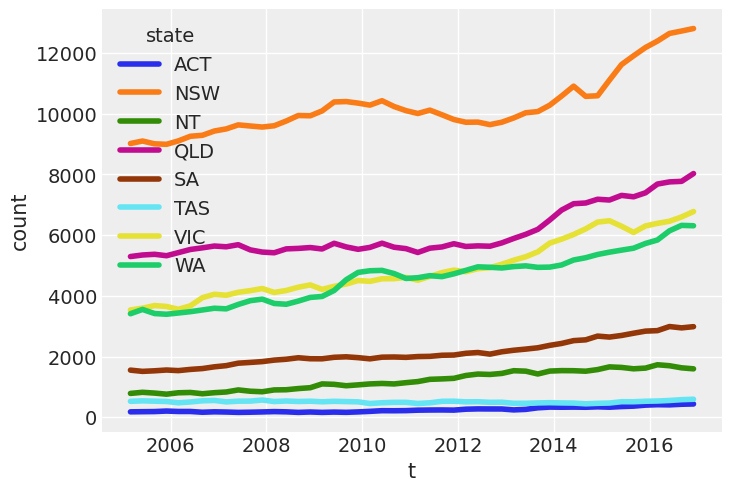

In [8]:
# Prison count by state
prison_state = prison.groupby(['t','state'])['count'].sum().reset_index()
sns.lineplot(data=prison_state, x = "t", y = "count", hue = "state");

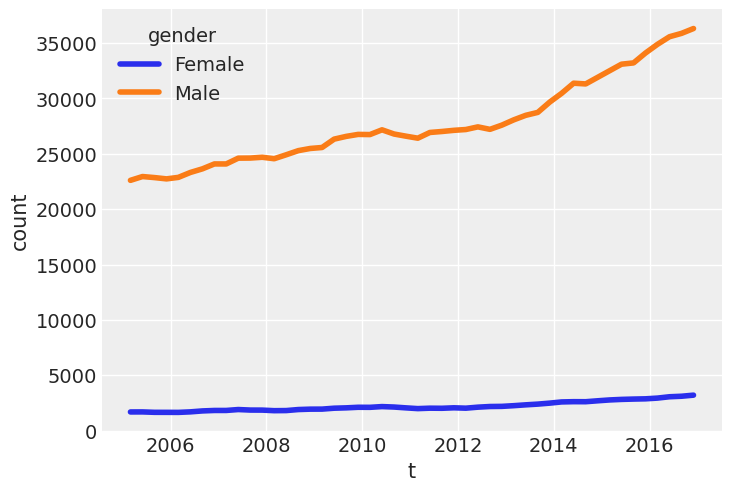

In [9]:
# Prison count by gender
prison_gender = prison.groupby(['t','gender'])['count'].sum().reset_index()
sns.lineplot(data=prison_gender, x = "t", y = "count", hue = "gender");

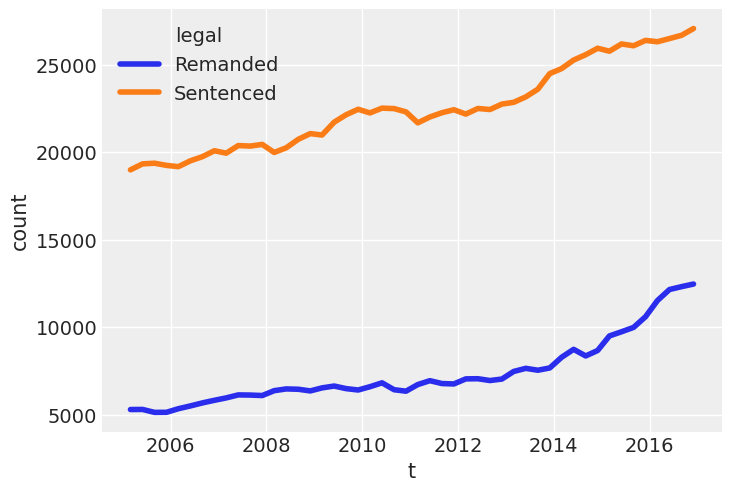

In [10]:
# Prison count by legal
prison_legal = prison.groupby(['t','legal'])['count'].sum().reset_index()
sns.lineplot(data=prison_legal, x = "t", y = "count", hue = "legal");

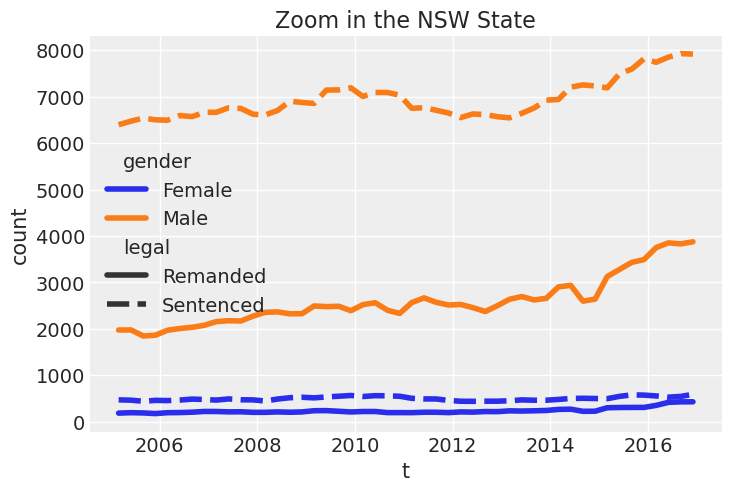

In [11]:
# Zoom in the NSW state
sns.lineplot(data=prison.query("state == 'NSW'"), x = "t", y = "count", hue = "gender", style="legal").set_title("Zoom in the NSW State");

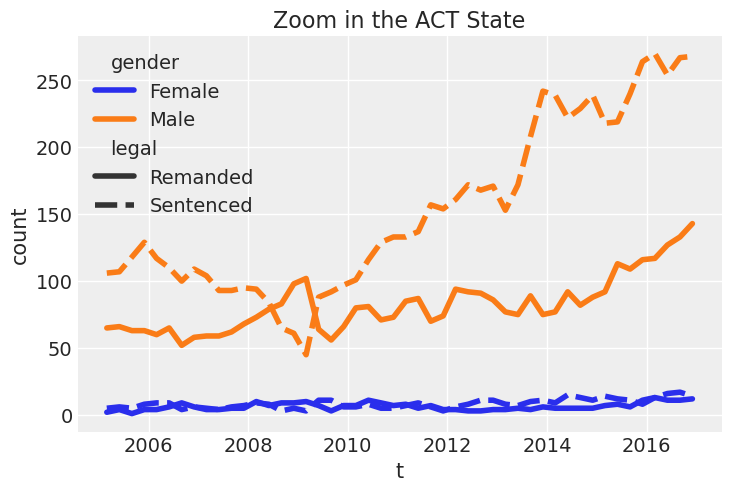

In [12]:
# Zoom in the ACT state
sns.lineplot(data=prison.query("state == 'ACT'"), x = "t", y = "count", hue = "gender", style="legal").set_title("Zoom in the ACT State");

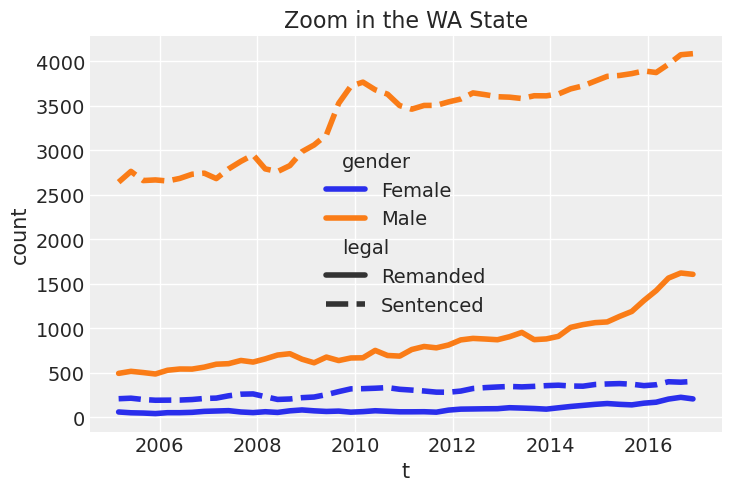

In [13]:
# Zoom in the WA state
sns.lineplot(data=prison.query("state == 'WA'"), x = "t", y = "count", hue = "gender", style="legal").set_title("Zoom in the WA State");

### Time series decomposition

In [14]:
prison_NSW = prison[prison['state'] == 'NSW'].groupby(['t'])['count'].sum()
prison_NSW = prison_NSW.reset_index().set_index('t')

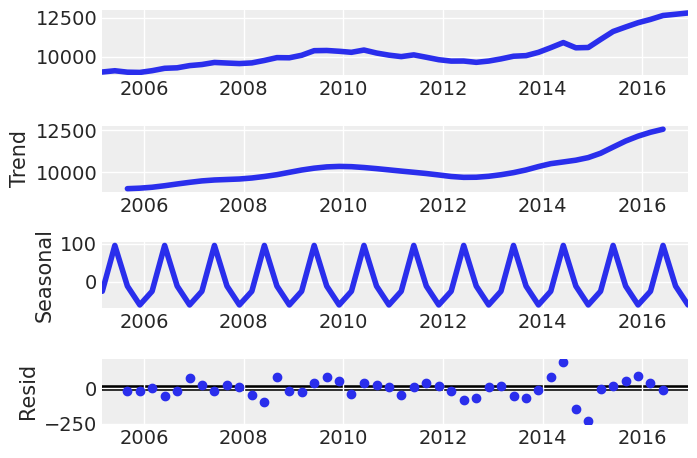

In [15]:
decomposition = sm.tsa.seasonal_decompose(prison_NSW, model='additive')
fig = decomposition.plot()
plt.show()

In [16]:
decomposition.seasonal

t
2005-03-01   -24.397727
2005-06-01    95.306818
2005-09-01   -10.829545
2005-12-01   -60.079545
2006-03-01   -24.397727
2006-06-01    95.306818
2006-09-01   -10.829545
2006-12-01   -60.079545
2007-03-01   -24.397727
2007-06-01    95.306818
2007-09-01   -10.829545
2007-12-01   -60.079545
2008-03-01   -24.397727
2008-06-01    95.306818
2008-09-01   -10.829545
2008-12-01   -60.079545
2009-03-01   -24.397727
2009-06-01    95.306818
2009-09-01   -10.829545
2009-12-01   -60.079545
2010-03-01   -24.397727
2010-06-01    95.306818
2010-09-01   -10.829545
2010-12-01   -60.079545
2011-03-01   -24.397727
2011-06-01    95.306818
2011-09-01   -10.829545
2011-12-01   -60.079545
2012-03-01   -24.397727
2012-06-01    95.306818
2012-09-01   -10.829545
2012-12-01   -60.079545
2013-03-01   -24.397727
2013-06-01    95.306818
2013-09-01   -10.829545
2013-12-01   -60.079545
2014-03-01   -24.397727
2014-06-01    95.306818
2014-09-01   -10.829545
2014-12-01   -60.079545
2015-03-01   -24.397727
2015-06-01    

In [17]:
decomposition.trend

t
2005-03-01          NaN
2005-06-01          NaN
2005-09-01     9039.375
2005-12-01     9069.625
2006-03-01     9124.375
2006-06-01     9214.250
2006-09-01     9318.375
2006-12-01     9414.625
2007-03-01     9499.750
2007-06-01     9554.375
2007-09-01     9583.750
2007-12-01     9612.750
2008-03-01     9672.000
2008-06-01     9761.625
2008-09-01     9869.125
2008-12-01    10008.625
2009-03-01    10144.375
2009-06-01    10253.875
2009-09-01    10329.875
2009-12-01    10358.875
2010-03-01    10343.625
2010-06-01    10292.250
2010-09-01    10226.750
2010-12-01    10153.500
2011-03-01    10080.750
2011-06-01    10010.125
2011-09-01     9937.500
2011-12-01     9852.125
2012-03-01     9762.125
2012-06-01     9710.625
2012-09-01     9717.375
2012-12-01     9773.500
2013-03-01     9865.750
2013-06-01     9989.500
2013-09-01    10149.625
2013-12-01    10349.250
2014-03-01    10521.500
2014-06-01    10623.000
2014-09-01    10727.375
2014-12-01    10881.875
2015-03-01    11137.625
2015-06-01    

### Forecasting with ARIMA

In [18]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [19]:
all_results = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(prison_NSW,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            all_results.append([param, param_seasonal, results.aic])
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1004.1307036111918
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:953.0843374691915
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:601.3389058296673
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:402.8821222049159
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:601.9305678994049
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:692.1210983100746
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:415.5519266385286
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:392.8724045681669
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:952.7858326258304
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3730.7061488798504
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:547.7182349799803
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:360.8993365240597
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:570.2342935363464
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1433148737.292445
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:392.4228324179014
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:362.81647901810834
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:614.8809303041113
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1306.762401254247
ARIMA(0

In [20]:
def sort_sublist(sub_li, i): 
    # reverse = None (Sorts in Ascending order) 
    # key is set to sort using second element of  
    # sublist lambda has been used 
    sub_li.sort(key = lambda x: x[i]) 
    return sub_li 

In [21]:
# Best result
sort_sublist(all_results, 2)[0]

[(0, 1, 1), (1, 1, 1, 12), 279.5848396035702]

In [22]:
mod = sm.tsa.statespace.SARIMAX(prison_NSW,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          1.0000     42.274      0.024      0.981     -81.855      83.855
ar.S.L12       0.0660      0.028      2.328      0.020       0.010       0.122
ma.S.L12      -1.0084     41.934     -0.024      0.981     -83.197      81.180
sigma2       1.61e+04      0.003   6.12e+06      0.000    1.61e+04    1.61e+04


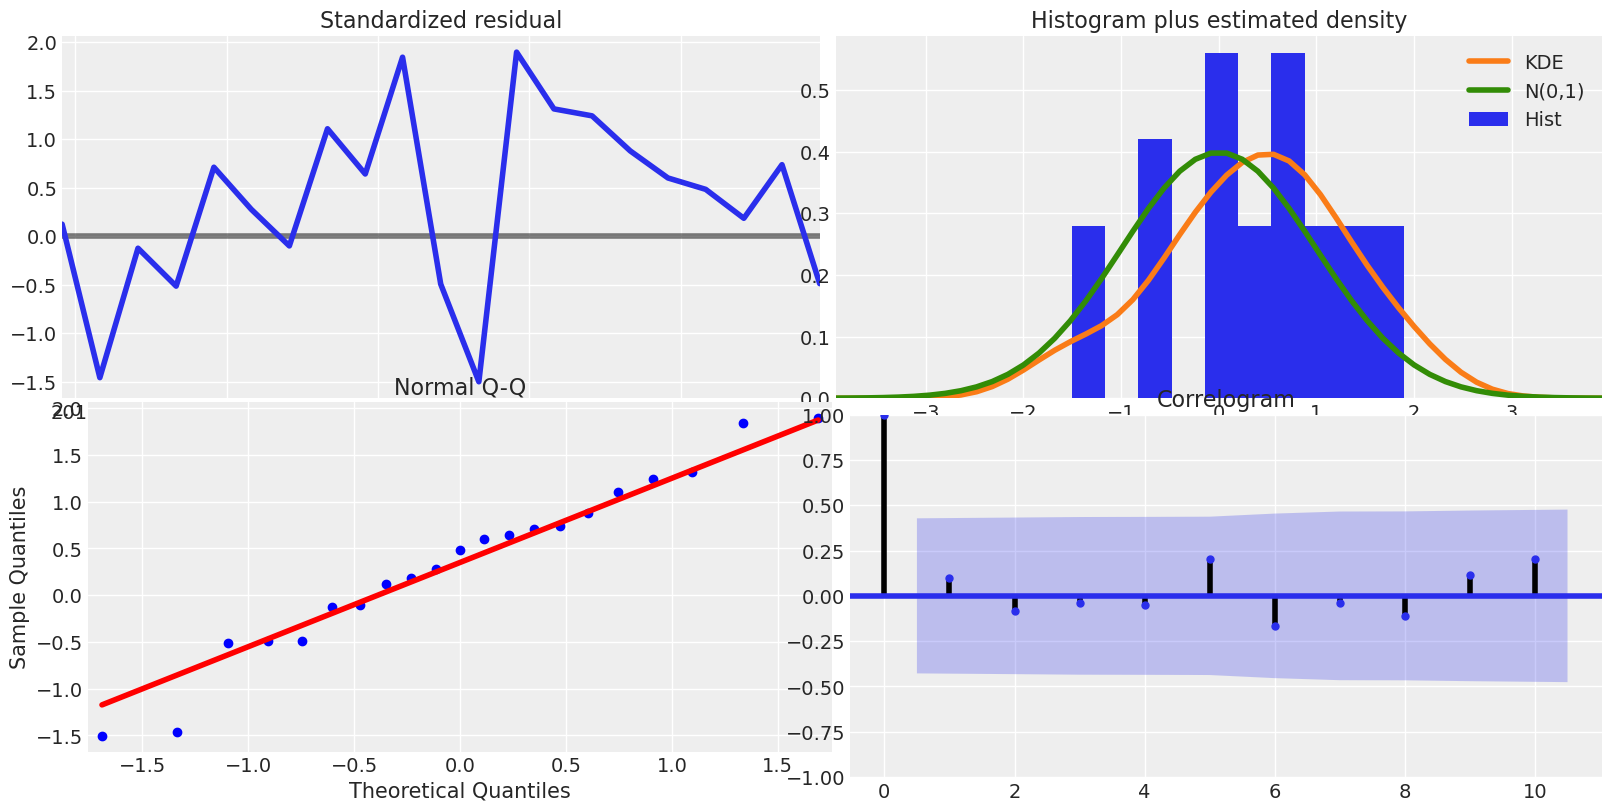

In [23]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

### Forecast

In [24]:
from datetime import datetime

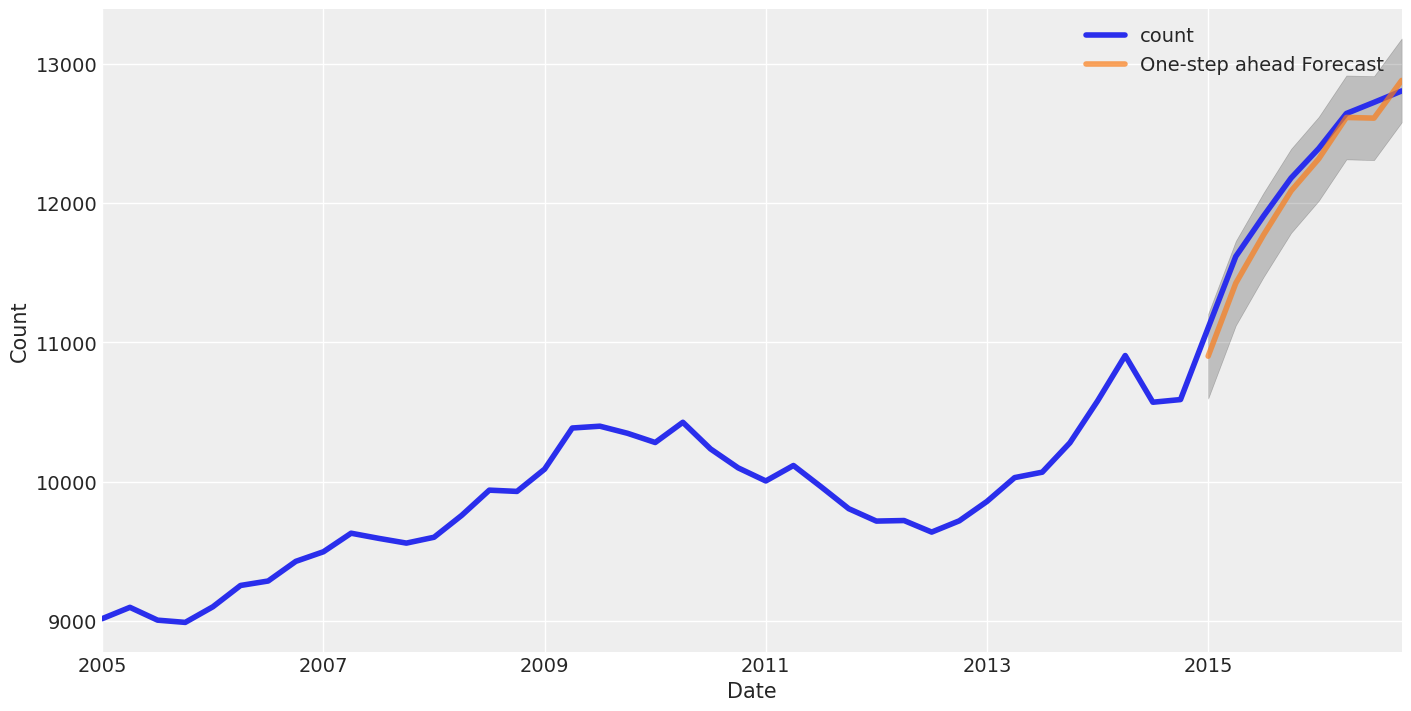

In [25]:
pred = results.get_prediction(start=datetime(2015, 3, 1), dynamic=False)
pred_ci = pred.conf_int()
ax = prison_NSW['2005':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Count')
plt.legend()
plt.show()

In [26]:
y_forecasted = pred.predicted_mean
y = prison_NSW['2015-03-01':]
mse = ((y_forecasted.values - y.values.T) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 16238.76


In [27]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 127.43


### Producing and visualizing forecasts

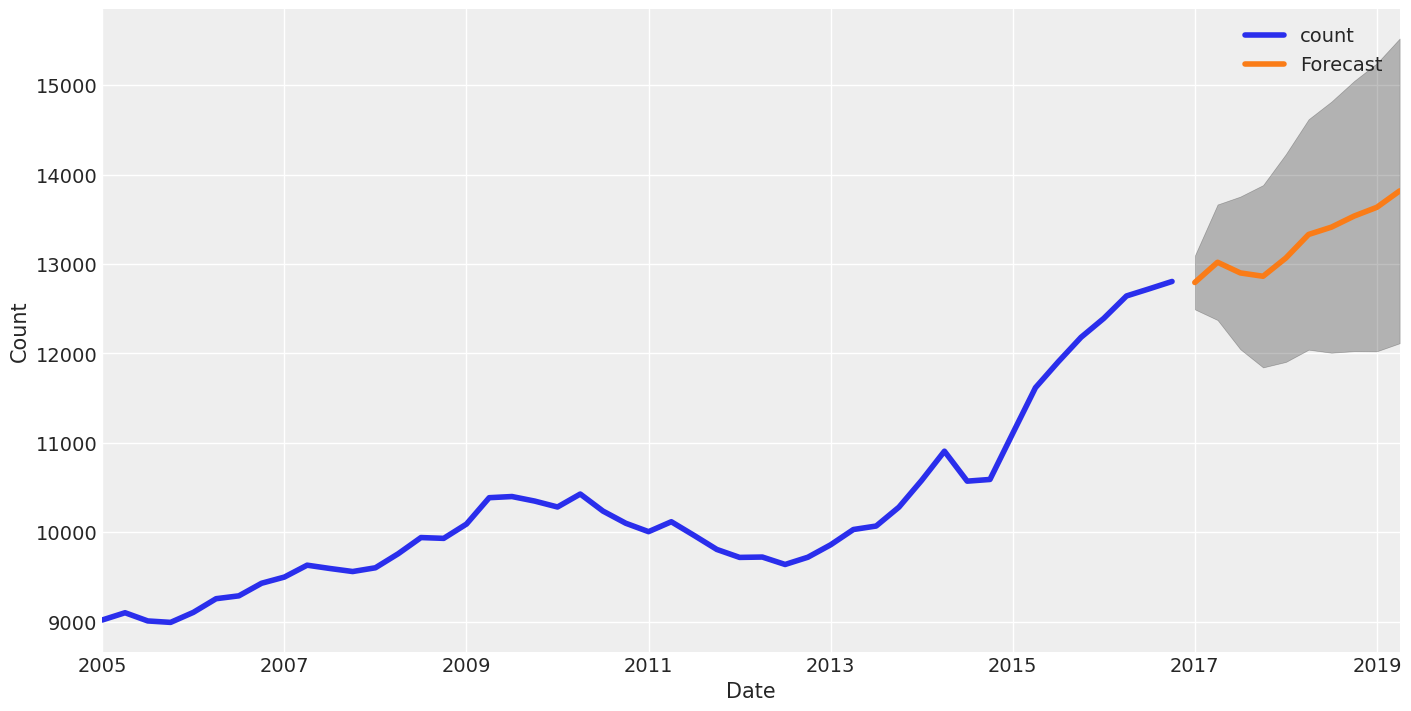

In [28]:
pred_uc = results.get_forecast(steps=10)
pred_ci = pred_uc.conf_int()
ax =prison_NSW.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Count')
plt.legend()
plt.show()

## Time Series of NSW vs. WA

In [29]:
NSW = prison.loc[prison['state'] == 'NSW'].groupby(['t'])['count'].sum().reset_index().set_index('t')
WA = prison.loc[prison['state'] == 'WA'].groupby(['t'])['count'].sum().reset_index().set_index('t')
NSW.shape, WA.shape

((48, 1), (48, 1))

In [30]:
NSW_WA = NSW.merge(WA, how='inner', on='t')
NSW_WA.rename(columns={'count_x': 'NSW_count', 'count_y': 'WA_count'}, inplace=True)
NSW_WA.head()

,NSW_count,WA_count
t,,
2005-03-01,9018,3410
2005-06-01,9099,3551
2005-09-01,9007,3416
2005-12-01,8991,3393
2006-03-01,9103,3434


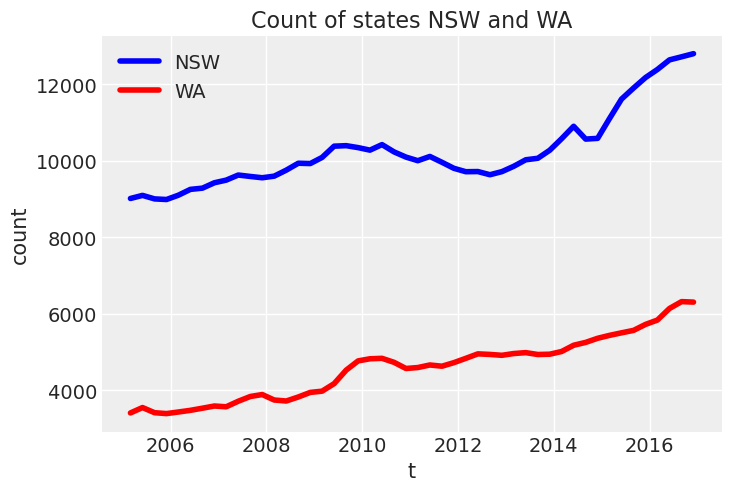

In [31]:
plt.plot(NSW_WA.index, NSW_WA['NSW_count'], 'b-', label = 'NSW')
plt.plot(NSW_WA.index, NSW_WA['WA_count'], 'r-', label = 'WA')
plt.xlabel('t'); 
plt.ylabel('count'); 
plt.title('Count of states NSW and WA')
plt.legend();

# Our Model

In [32]:
X = np.tile(np.arange(NSW.shape[0]).reshape(NSW.shape[0],1), (1,2))
y = NSW_WA.values

In [33]:
from pymc3.distributions import distribution
from pymc3.distributions.continuous import get_tau_sigma, Normal, Flat

class AR(distribution.Continuous):

    def __init__(self, k, tau_e, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.k = k = tt.as_tensor_variable(k)
        self.tau_e = tau_e = tt.as_tensor_variable(tau_e)
        self.tau = tau_e * (1 - k ** 2)
        self.mode = tt.as_tensor_variable(0.0)

    def logp(self, x):
        k = self.k
        tau_e = self.tau_e  # innovation precision
    
        x_im1 = x[:-1]
        x_i = x[1:]
        boundary = Normal.dist(0.0, tau=tau_e).logp

        innov_like = Normal.dist(k * x_im1, tau=tau_e).logp(x_i)
        return boundary(x[0]) + tt.sum(innov_like)

## Single series

In [273]:
X = np.arange(48)

# Trend value could be around
(decomposition.trend[-3] - decomposition.trend[3])/(48-3-3)

83.16666666666667

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 29400
Interrupted at 29,399 [14%]: Average Loss = 2.6352e+05
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_pre, tau, phi, b, a]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 10 seconds.


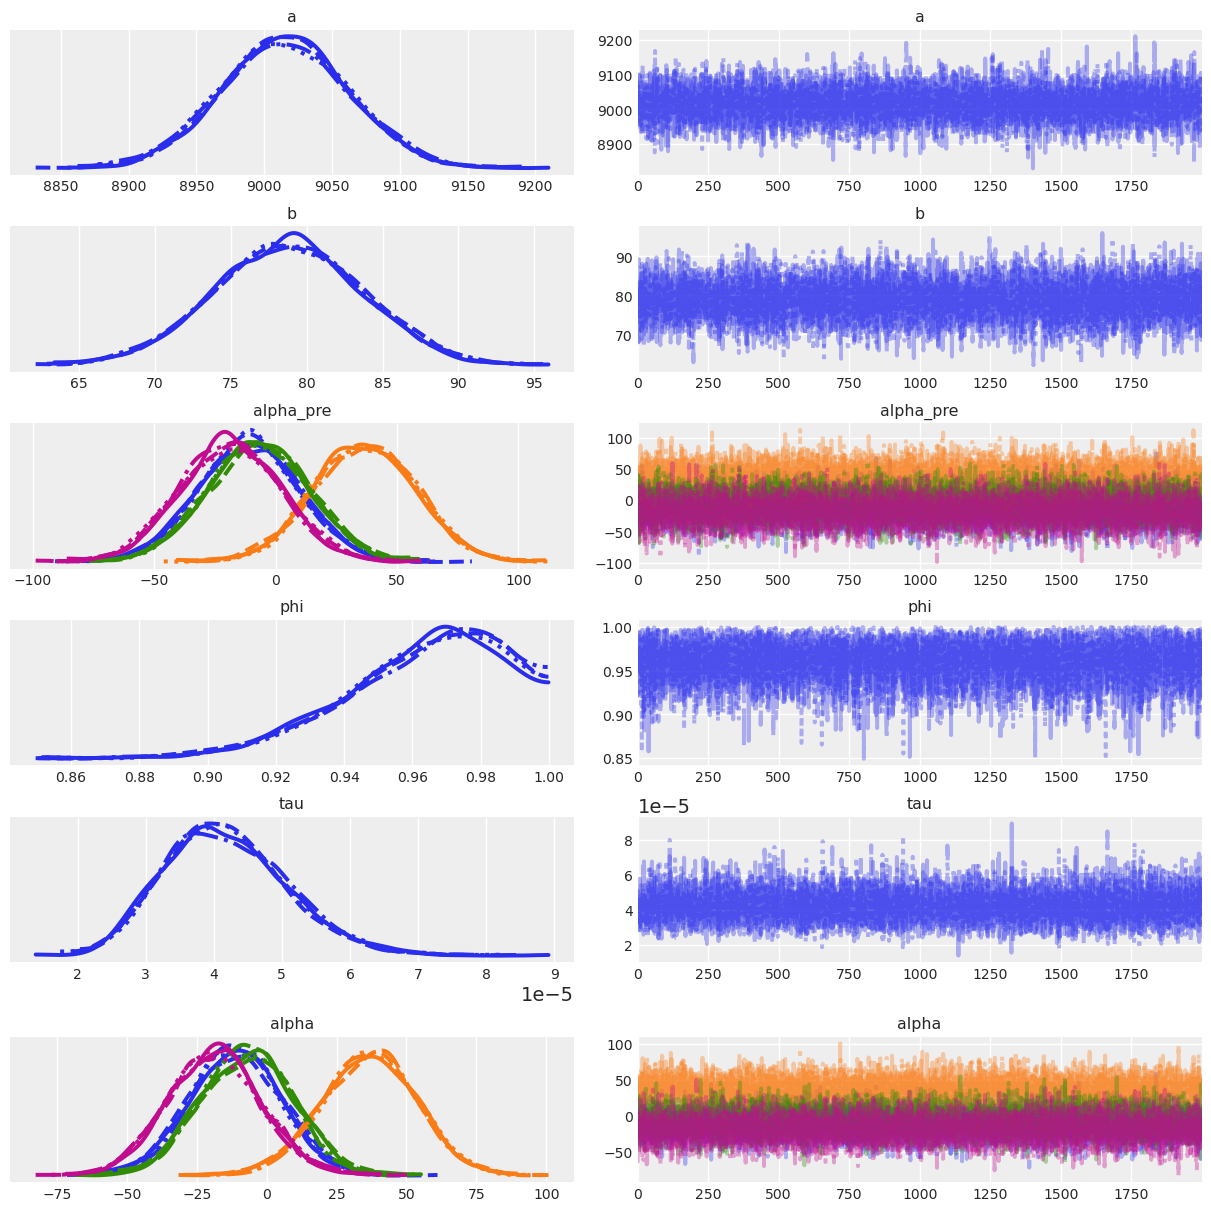

In [274]:
# trend + seasonality + AR(1) errors

y_ = shared(y[:,0])
with pm.Model() as model:
    a = pm.Normal("a",y[0,0], 50)
    b = pm.Normal("b",80, 5)

    # Regularizing prior for phi
    phi = pm.Bound(pm.Laplace, lower = -1, upper=1)("phi", 0.0, 0.05)
    tau = pm.HalfNormal("tau", 0.2)
    
    alpha_pre = pm.Normal('alpha_pre', 0, 25, shape=4)
    alpha = pm.Deterministic('alpha', alpha_pre - tt.mean(alpha_pre,axis=0))
    seasonality = alpha[np.arange(y.shape[0])%4]
    
    
    mu = a + X * b + seasonality

    err = y_- mu
    y_pred = AR("y_pred", k=phi, tau_e=tau, observed=err)
    trace = pm.sample(draws=2000, 
                      tune=4000, 
                      init="advi+adapt_diag",
                      target_accept=0.90)

pm.plots.traceplot(trace);

In [285]:
az.summary(trace, var_names=['~alpha-pre'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,9015.092,47.135,8926.975,9103.092,0.482,0.341,9547.0,9545.0,9572.0,5971.0,1.0
b,78.792,4.874,69.675,87.910,0.050,0.036,9381.0,9381.0,9385.0,5635.0,1.0
alpha_pre[0],-10.966,20.904,-50.835,27.598,0.236,0.209,7821.0,5024.0,7815.0,5702.0,1.0
alpha_pre[1],36.688,20.914,-1.221,76.221,0.237,0.174,7795.0,7185.0,7797.0,5881.0,1.0
alpha_pre[2],-7.066,20.800,-44.192,33.645,0.218,0.214,9112.0,4725.0,9097.0,6191.0,1.0
alpha_pre[3],-18.551,21.014,-56.209,21.802,0.236,0.191,7944.0,6045.0,7953.0,5856.0,1.0
phi,0.963,0.024,0.922,1.000,0.000,0.000,6799.0,6681.0,4742.0,2606.0,1.0
tau,0.000,0.000,0.000,0.000,0.000,0.000,9558.0,9369.0,9347.0,6025.0,1.0
alpha[0],-10.993,16.368,-41.028,20.713,0.159,0.161,10537.0,5161.0,10540.0,5477.0,1.0
alpha[1],36.662,16.845,5.324,68.460,0.180,0.132,8741.0,8188.0,8764.0,6004.0,1.0


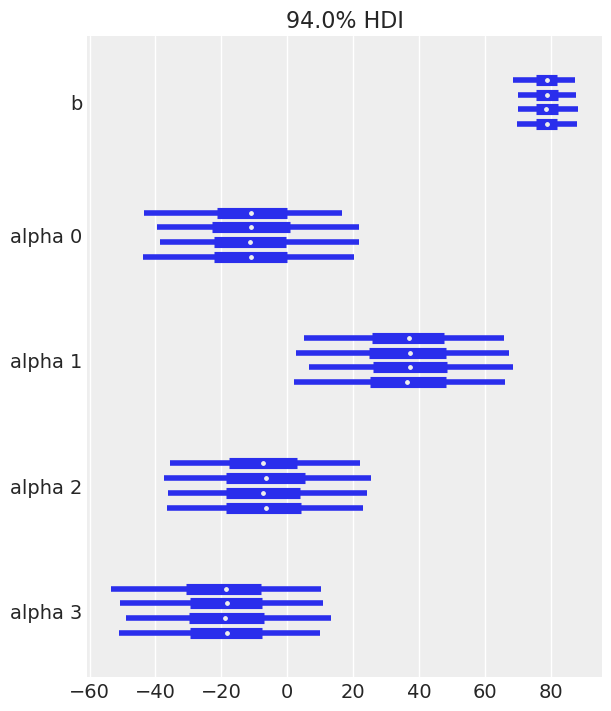

In [293]:
pm.forestplot(trace, var_names=['~alpha_pre', '~a', '~phi', '~tau']);

In [315]:
df_trace = pm.trace_to_dataframe(trace)
df_trace = df_trace[['a', 'b', 'phi', 'tau', 'alpha__0', 'alpha__1', 'alpha__2', 'alpha__3']]

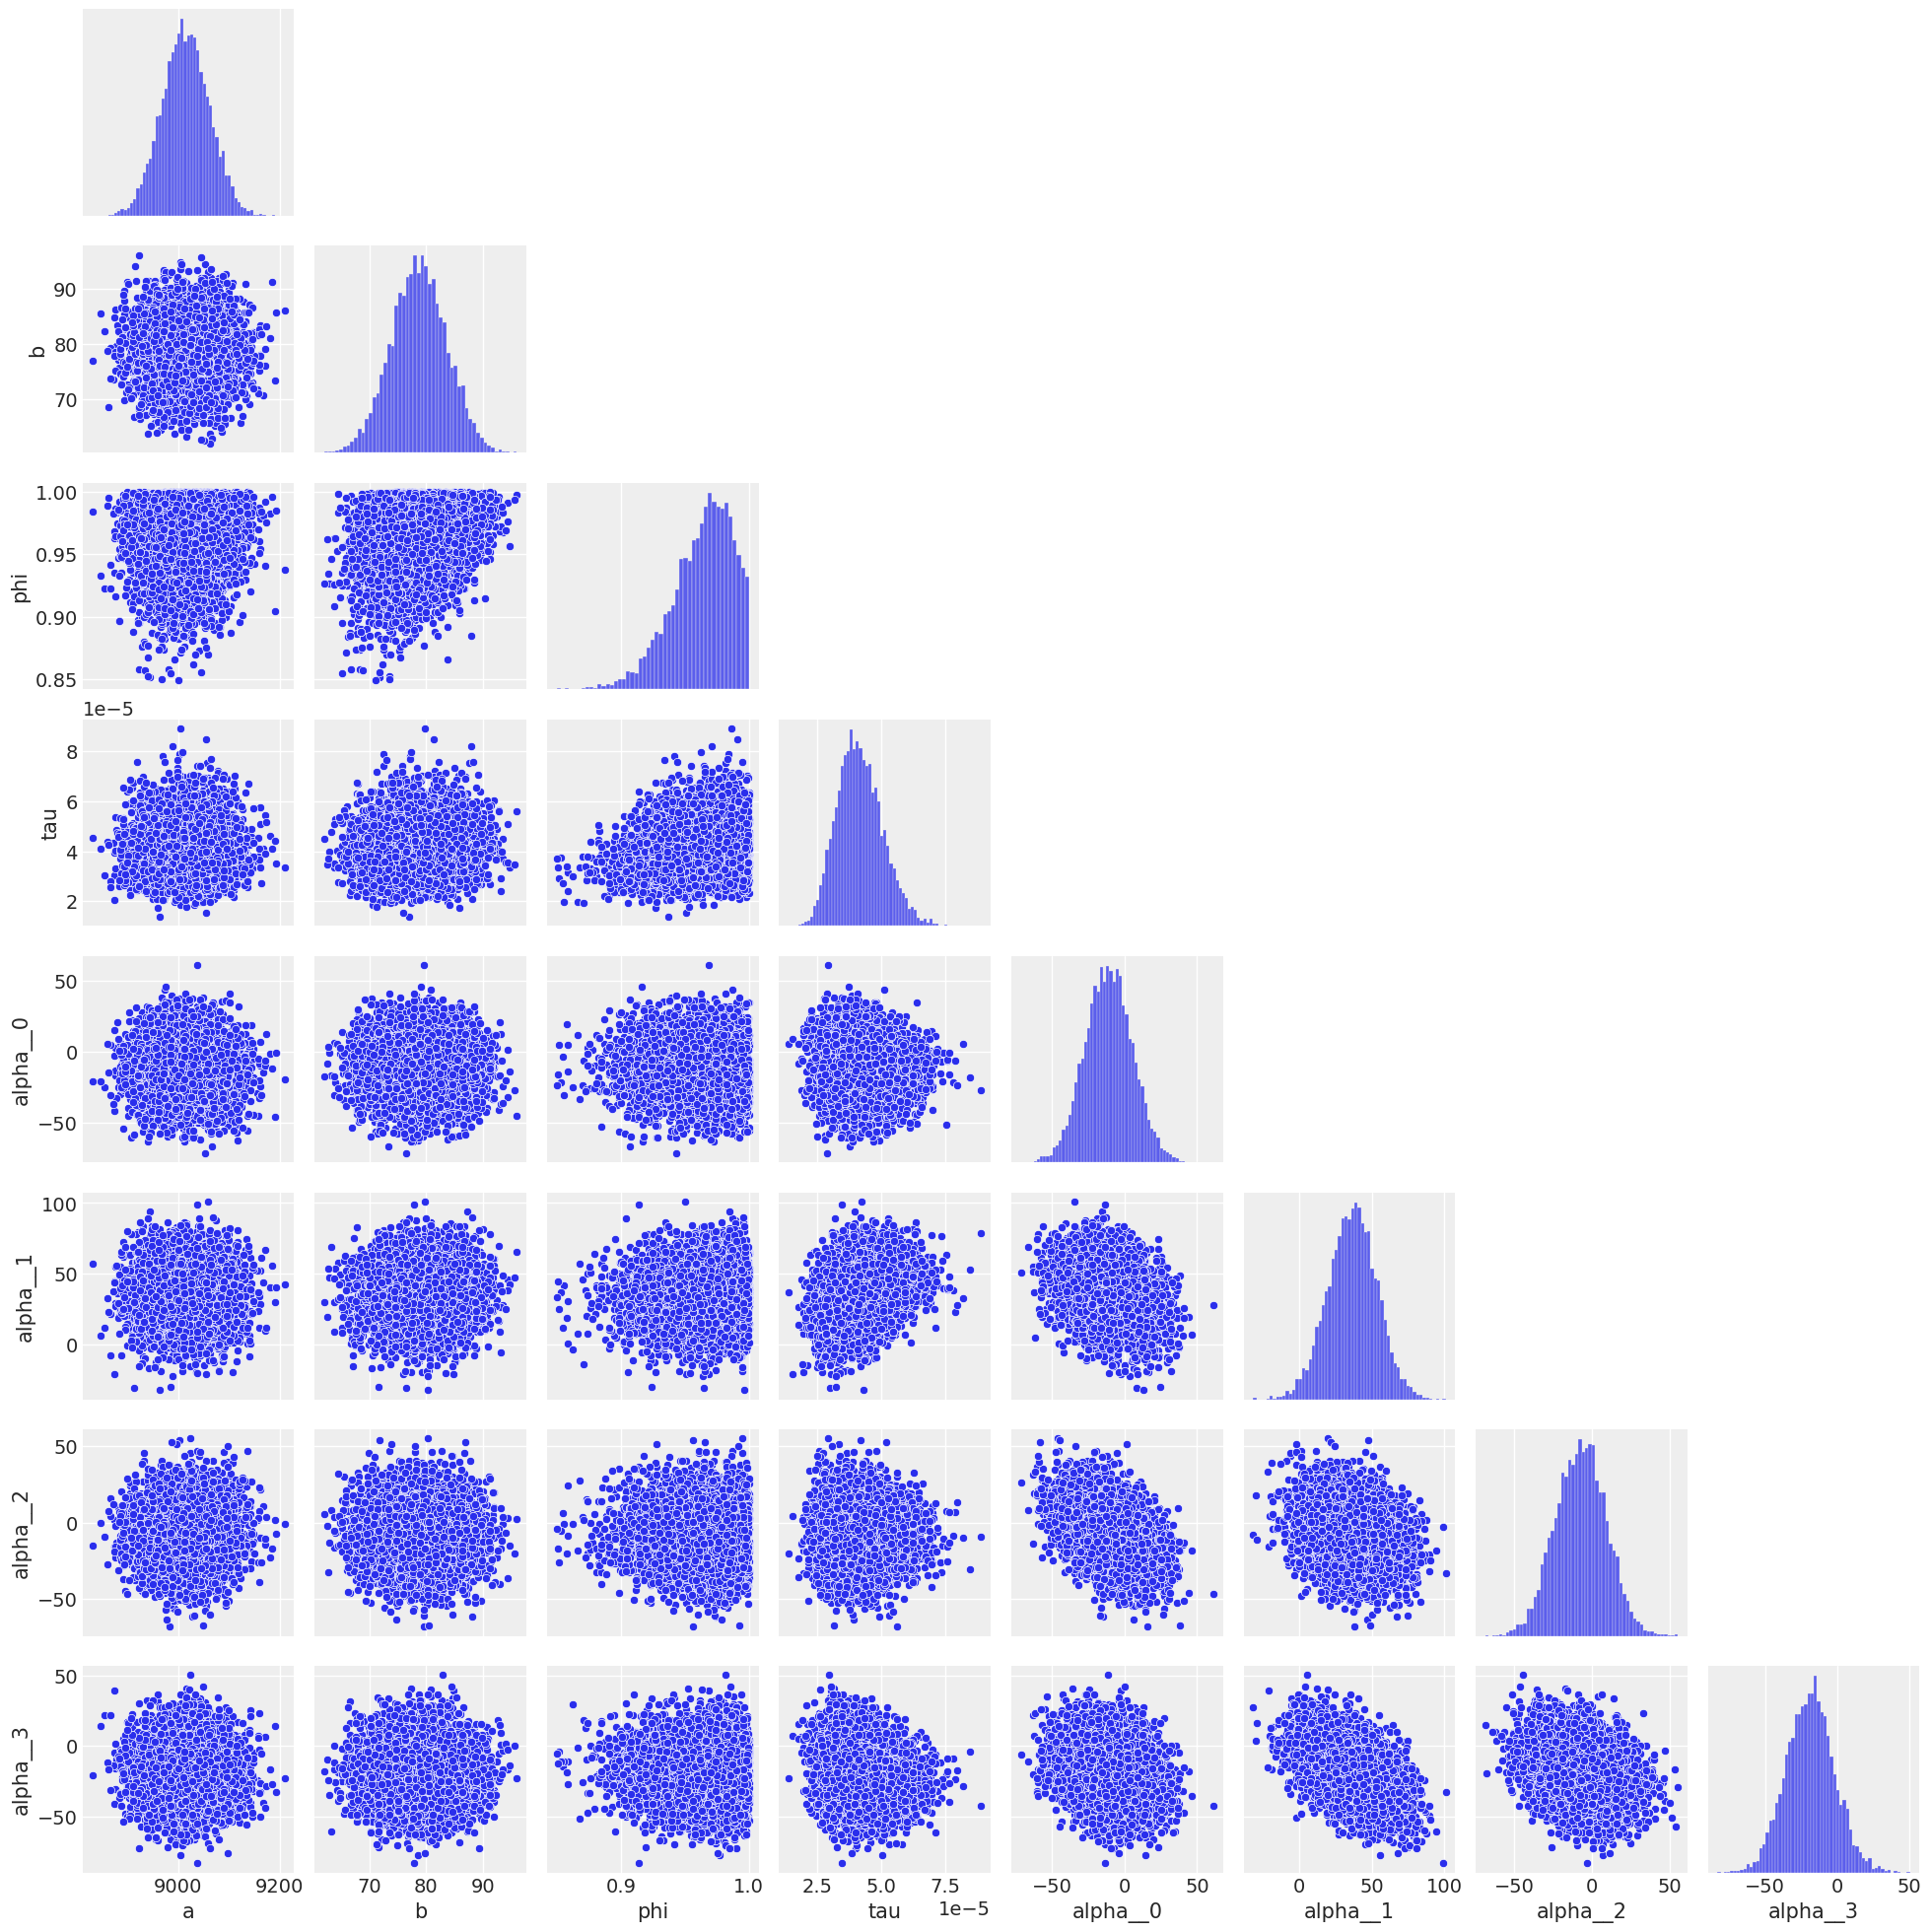

In [317]:
sns.pairplot(df_trace, corner=True);

Phi and b are correlated as we can see above that is why when we get an higher trend the coefficient of the AR process is a little bit lower.

### Fitting

In [276]:
CI_a = np.percentile(trace['a'],axis=0,q=[2.5,50, 97.5])
CI_b = np.percentile(trace['b'],axis=0,q=[2.5,50, 97.5])
CI_alpha = np.percentile(trace['alpha'],axis=0,q=[2.5,50, 97.5])
CI_phi = np.percentile(trace['phi'],axis=0,q=[2.5,50, 97.5])
CI_tau = np.percentile(trace['tau'],axis=0,q=[2.5,50, 97.5])

mu = CI_a.reshape(1, 3) + CI_b.reshape(1, 3) * X.reshape(y.shape[0],1) + CI_alpha.T[np.arange(y.shape[0])%4].reshape(y.shape[0],3)

res = y[:,0].reshape(y.shape[0],1) - mu
err = np.zeros((y.shape[0],3))
for i in range(1, y.shape[0]):
    err[i] = CI_phi * res[i-1]
    
y_pred = np.random.normal(mu + err, np.sqrt(1/CI_tau))

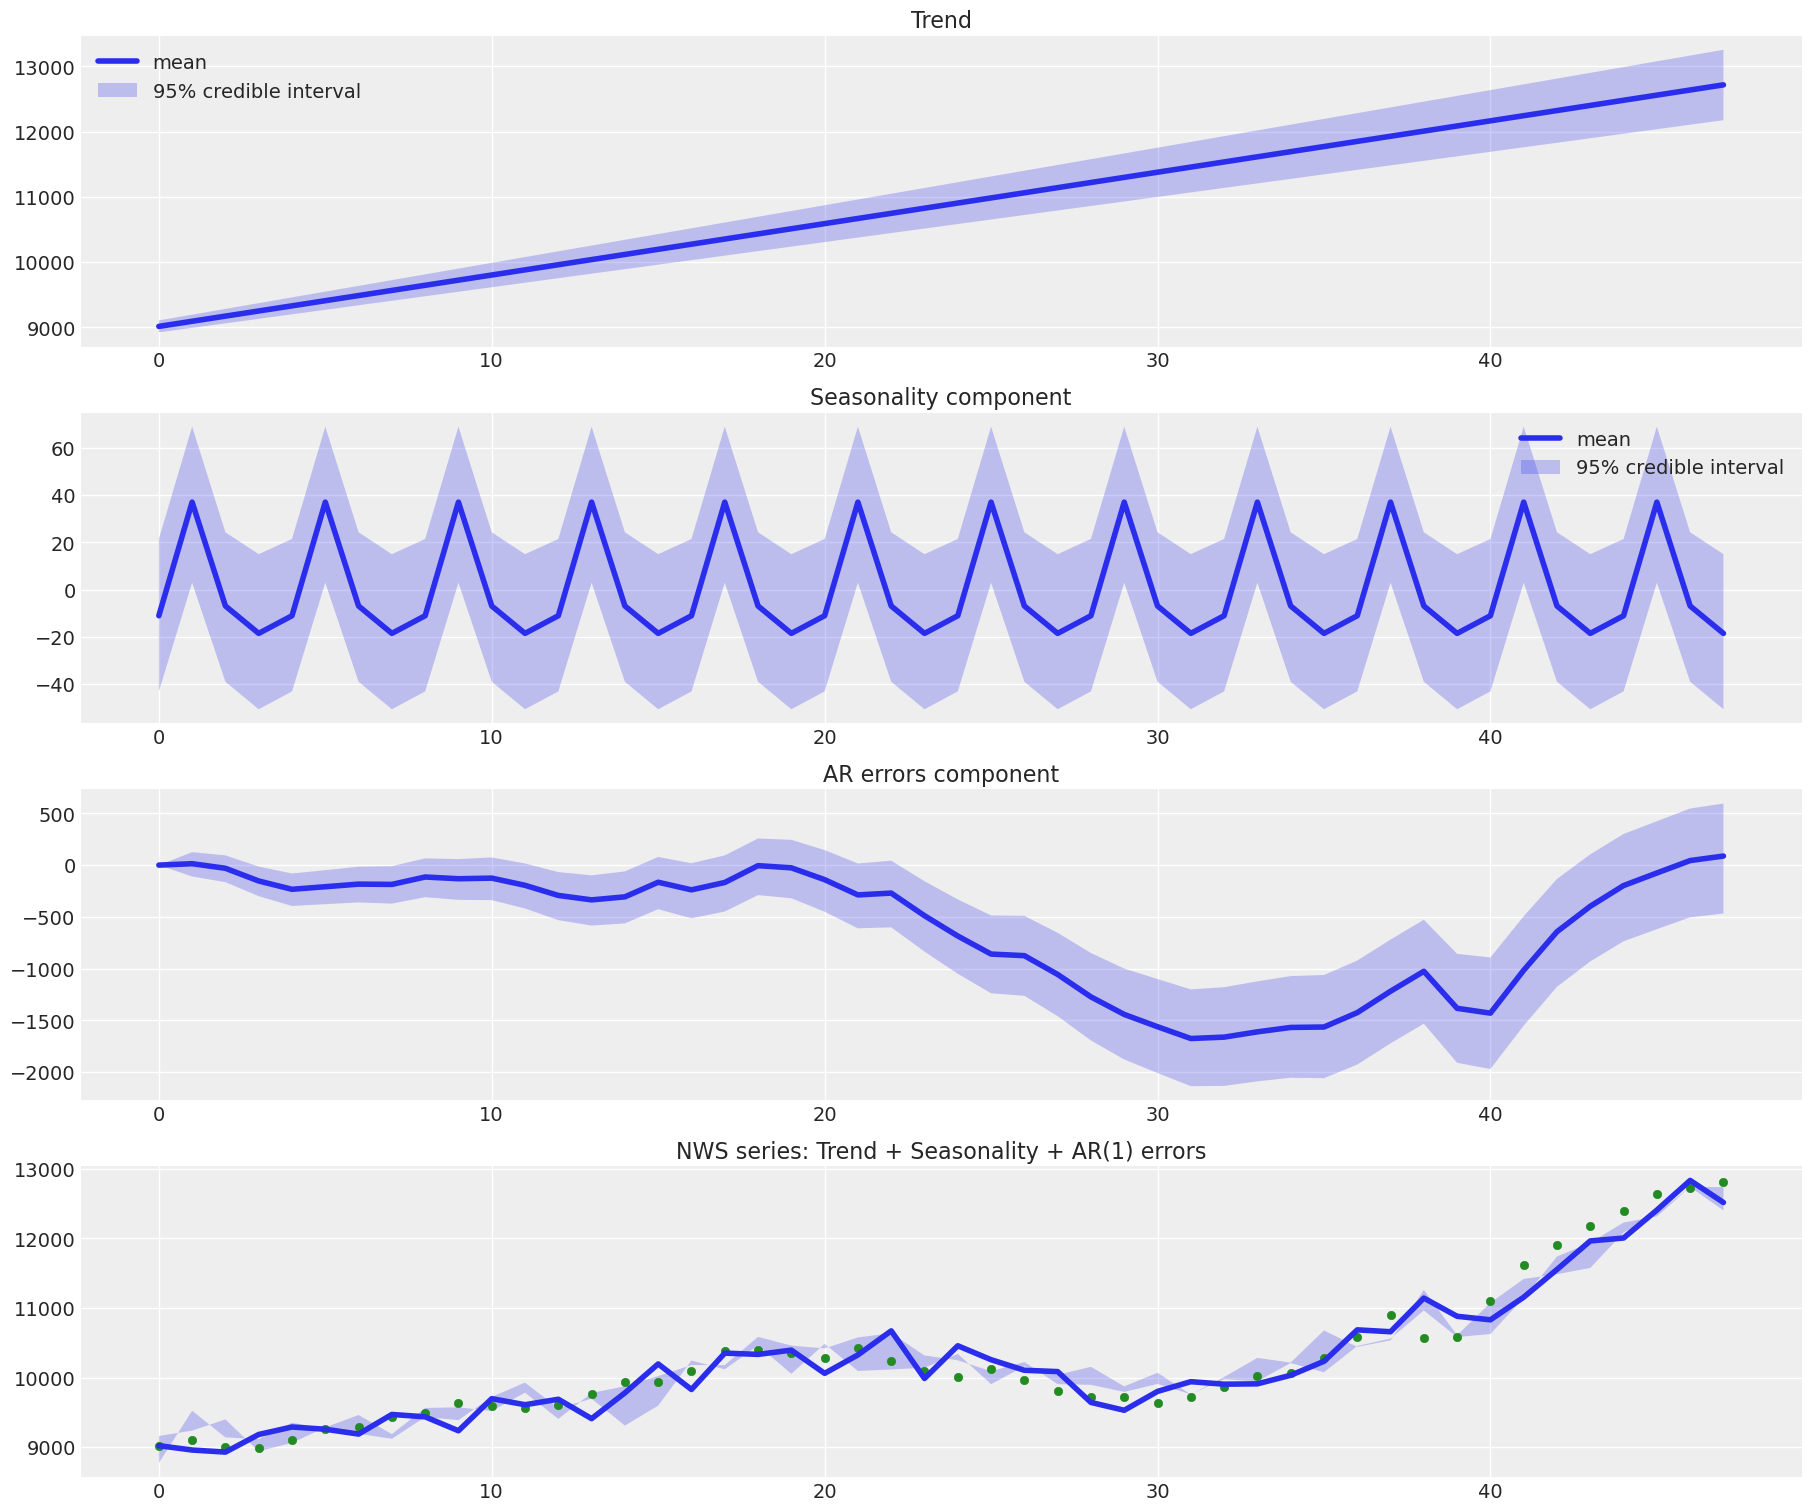

In [277]:
fig, ax = plt.subplots(4, 1, figsize=(18,15))

# Level + Trend
ax[0].plot(np.mean(trace['a'], axis=0) + np.mean(trace['b'], axis=0) * X , label="mean")
ax[0].fill_between(np.arange(y.shape[0]),CI_a[0] + CI_b[0] * X,
                 CI_a[2] + CI_b[2] * X,
                 alpha=0.25,label='95% credible interval')
ax[0].set_title("Trend")
ax[0].legend()

# Seasonality
ax[1].plot(CI_alpha[1][np.arange(y.shape[0])%4], label="mean")
ax[1].fill_between(np.arange(y.shape[0]),CI_alpha[0][np.arange(y.shape[0])%4],
                 CI_alpha[2][np.arange(y.shape[0])%4],
                 alpha=0.25,label='95% credible interval')
ax[1].legend()
ax[1].set_title("Seasonality component")

# AR(1) errors
ax[2].plot(err[:,1], label="mean")
ax[2].fill_between(np.arange(y.shape[0]),err[:,0],
                 err[:,2],
                 alpha=0.25,label='95% credible interval')
ax[2].set_title("AR errors component")

# Level + Trend + Seasonality + AR(1) errors
ax[3].plot(y_pred[:,1], label="mean")
ax[3].fill_between(np.arange(y.shape[0]),y_pred[:,0],
                 y_pred[:,2],
                 alpha=0.25,label='95% credible interval')
ax[3].scatter(np.arange(y.shape[0]),y[:,0], color="forestgreen")
ax[3].set_title("NWS series: Trend + Seasonality + AR(1) errors");

### Forecasting

In [278]:
n = 20 # number of points to estimate in the future

forec = np.zeros((n,3))
for i in range(n):
    # for i = 0 we are iterating over the last real point to compute the first point forecasting
    mu = CI_a.reshape(1,3) + CI_b.reshape(1,3) * np.arange(y.shape[0] + i).reshape(y.shape[0] + i, 1) + CI_alpha.T[np.arange(y.shape[0]+i)%4]
    # last point residual
    res = y[-1:,0] - mu[-1:]
    # new point forecasting
    forec[i] = np.random.normal(CI_phi * res + mu[-1:], np.sqrt(1/CI_tau))

In [279]:
y_forec = np.concatenate((np.tile(y[:,0].reshape(y.shape[0],1), (1, 3)), forec), axis=0)

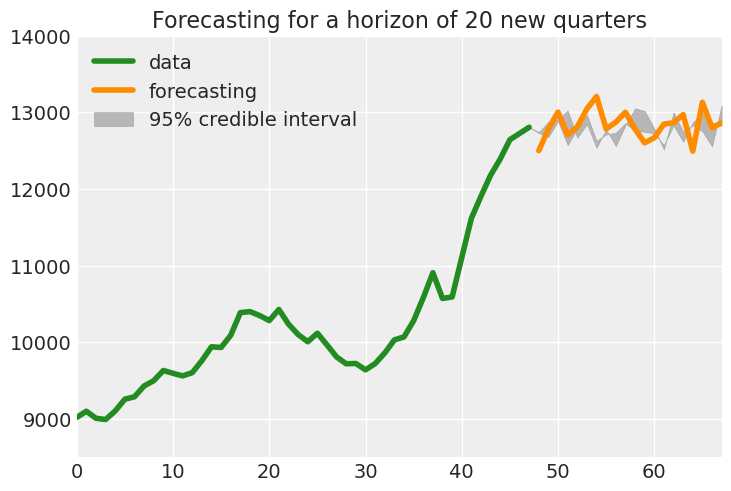

In [281]:
plt.plot(np.arange(y.shape[0]), y_forec[:y.shape[0],1], color='forestgreen', label="data")
plt.plot(np.arange(y.shape[0],n+y.shape[0]), y_forec[y.shape[0]:,1], color="darkorange", label="forecasting")
plt.fill_between(np.arange(y.shape[0]+n),y_forec[:,0],
                 y_forec[:,2],
                 color = "grey",
                 alpha=0.5,
                 label='95% credible interval')
plt.title("Forecasting for a horizon of {} new quarters".format(n))
plt.axis([0,y.shape[0] + n-1,8500, 14000])
plt.legend();

## Aggregated over the 8 states

### Statistical Analysis

Compare gender effect

# Adding groups 
### 12 series: 3 states, 2 gender and 2 legal

# Fitting

Plot the fitting but not using the ppc because AR dist does not have a random method

In [ ]:
import math
fig, ax = plt.subplots(2, 5, figsize=(18,10), sharey=True)

credible_intervals = np.percentile(ppc['y_pred'],axis=0,q=[2.5,50, 97.5])


for i in range(2*5):
    ax[int(i/5)][i%5].scatter(np.arange(nTime),y_[:,i], label="y (series={})".format(i))
    ax[int(i/5)][i%5].fill_between(np.arange(nTime),credible_intervals[0,:,i],
                 credible_intervals[2,:,i],
                 alpha=0.25,label='95% credible interval')
    ax[int(i/5)][i%5].plot(lin_reg[:,i], label="lin reg")
    ax[int(i/5)][i%5].legend();

# Forecasting

# Next steps:

1. Test VAR insteat of AR on errors
2. Test non-linear effects between groups
3. Test stochasticity of trend and seasonality
4. Test multivariate normal to allow parameters to covary